# Robustness
This code was adapted from the code written by Michael Lees and Debraj Roy

## Import libraries


In [3]:
import networkx as nx #import NetworkX
import numpy as np #import numpy for ...
#force drawing of graphs inline for ipython notebook
%matplotlib inline 
import matplotlib.pyplot as plt #import matplotlib for plotting/drawing grpahs
import matplotlib.patches as mpatches #for legends in the graph
from __future__ import unicode_literals #allow UTF characters in graph labels
import random # for random choice function
import copy # this is use for making deep copies of lists
from tqdm import tqdm #nice library for progress bars
import sys #for writing output to stderr

## Import networks

In [4]:
with open('vi-wiki-talk.csv', 'rb') as file_handle:
    next(file_handle, '')   # skip the header line (NOTE the first list in the CSV file doesn't contain an edge)
    V_orig = nx.read_edgelist(file_handle, delimiter='\t', create_using=nx.DiGraph(), 
                         nodetype=str, data=(('time', str),), encoding="utf-8")

V = copy.deepcopy(V_orig)

with open('sv-wiki-talk.csv', 'rb') as file_handle:
    next(file_handle, '')   # skip the header line (NOTE the first list in the CSV file doesn't contain an edge)
    S_orig = nx.read_edgelist(file_handle, delimiter='\t', create_using=nx.DiGraph(), 
                         nodetype=str, data=(('time', str),), encoding="utf-8")
    
S = nx.Graph(S_orig)

with open('cy-wiki-talk.csv', 'rb') as file_handle:
    next(file_handle, '')   # skip the header line (NOTE the first list in the CSV file doesn't contain an edge)
    C_orig = nx.read_edgelist(file_handle, delimiter='\t', create_using=nx.DiGraph(), 
                         nodetype=str, data=(('time', str),), encoding="utf-8")
    
C = nx.Graph(C_orig)

print "done"

done


## Attack and fail function

In [5]:
def fail(G): #a python function that will remove a random node from the graph G
    n = random.choice(G.nodes())  #pick a random node
    G.remove_node(n) # remove that random node, attached edges automatically removed.
    
def attack_degree(G): #remove node with maximum degree
    degrees = G.degree() # get dcitonary where key is node id, value is degree
    max_degree = max(degrees.values()) # find maximum degree value from all nodes
    max_keys = [k for k,v in degrees.items() if v==max_degree] #get all nodes who have the maximum degree (may be more than one)
    G.remove_node(max_keys[0]) #remove just the first node with max degree, we will remove others next
    

## Experimental parameters

In [19]:
fraction_of_nodes_to_remove = 0.95 # remove until this fraction of all original nodes are removed

# For the Vietnamese network
NetworkSize_vi = V.order()
num_removals_vi = int(fraction_of_nodes_to_remove * NetworkSize_vi) #number of nodes to remove

# For the Swedish network
NetworkSize_sv = S.order()
num_removals_sv = int(fraction_of_nodes_to_remove * NetworkSize_sv) #number of nodes to remove

# For the Cyrillic network
NetworkSize_cy = C.order()
num_removals_cy = int(fraction_of_nodes_to_remove * NetworkSize_cy) #number of nodes to remove


print "defined parameters"

defined parameters


## Measuring Original Network Statistics

In [15]:
print "started kernel"

def diameter_ave_path_length(G):
    # We create our own function to do this so things are slightly faster, 
    # we can calculate diameter and avg path length at the same time
    max_path_length = 0
    total = 0.0
    for n in G: #iterate over all nodes
        path_length=nx.single_source_shortest_path_length(G, n) # generate shortest paths from node n to all others
        total += sum(path_length.values()) #total of all shortest paths from n
        if max(path_length.values()) > max_path_length: #keep track of longest shortest path we see.
            max_path_length = max(path_length.values())
    #print "finished iterations over all nodes"
    try:
        avg_path_length = total / (G.order()*(G.order() - 1))
    except ZeroDivisionError:
        avg_path_length = 0.0
    return max_path_length, avg_path_length

def network_statistics(n):
    """n is a network
    Return diameter (d), average path length (l) and giant component size (s) """
    #print "Started statistics"
    Gcc=sorted(nx.connected_component_subgraphs(n), key = len, reverse=True)
    G0=Gcc[0]
    #"Finished Giant component"
    d,l = diameter_ave_path_length(G0)
    s = float(G0.order()) / float(n.order())
    return d,l,s

print network_statistics(C)

started kernel
(8, 2.7692405596536673, 0.8918128654970761)


## Run Failures

In [17]:
#V = nx.Graph(V_orig)
#S = nx.Graph(S_orig)
C = nx.Graph(C_orig)
print "Finished preparing graphs"

def failing(network, removals, measure_every_X_removals=20):
    diameters = []
    path_lengths = []
    giant_component_sizes = []
    sys.stderr.write("---- Starting Experiments ----")
    sys.stderr.flush()
    # Remove removals nodes from the network.
    for x in tqdm(range(removals)):
        fail(network)
        # Calculate the network statistics for every X removals.
        if x % measure_every_X_removals == 0:
            d, l, s = network_statistics(network)
            diameters.append(d)
            path_lengths.append(l)
            giant_component_sizes.append(s)
    sys.stderr.write("---- Experiments finished ---- ")
    sys.stderr.flush()
    return diameters, path_lengths, giant_component_sizes

#V_diameters, V_path_lengths, V_gcs = failing(V, num_removals_vi)
print"Finished Vietnamese"
#S_diameters, S_path_lengths, S_gcs = failing(S, num_removals_sv)
print "Finished Swedish"
C_diameters, C_path_lengths, C_gcs = failing(C, num_removals_cy)

print "Done!"
            
        

100%|██████████████████████████████████████████████████████████████████████████████| 2121/2121 [02:21<00:00, 14.99it/s]
---- Experiments finished ---- 

Done!


In [18]:
print C_diameters
print C_path_lengths
print C_gcs


[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2]
[2.8290423632603647, 2.8300342825145752, 2.830211949927611, 2.822675754307579, 2.82709502007105, 2.828976955919656, 2.8295161214624303, 2.831009849309428, 2.8276860671730386, 2.828214482912828, 2.8296885585766334, 2.827855163820973, 2.8289040550842697, 2.80788068678029, 2.8092341158224023, 2.812286211370606, 2.8090619966131096, 2.8082677733543124, 2.8109168082349916, 2.8103959243343297, 2.805700728352662, 2.8045756850226122, 2.8068386502506253, 2.8052766224188197, 2.9323556588324626, 2.925694361403888, 2.925206131760125, 2.9206786786786787, 2.922401952203952, 2.923158425618661, 2.90495082039037, 2.941828822673123, 2.929368029739777, 2.9322962361990297, 2.932221671014098

## Plotting Failure


In [21]:
def plot_all():
    xvalues_vi = [(float(x)/float(NetworkSize_vi) * 20 for x in range(len(V_diameters)))]
    xvalues_sv = [(float(x)/float(NetworkSize_sv) * 20 for x in range(len(S_diameters)))]
    xvalues_cy = [(float(x)/float(NetworkSize_cy) * 20 for x in range(len(C_diameters)))]
    fig_size = [18,133]
    plt.rcParams.update({'font.size': 20, "figure.figsize": fig_size})

    # Plot diameter
    plt.plot(xvalues_vi, V_diameters, '--or', 
             xvalues_sv, S_diameters, '--xb', 
             xvalues_cy, C_diameters, '--vg')
    red_patch = mpatches.Patch(color='red', label='Vi')
    blue_patch = mpatches.Patch(color='blue', label='Sv')
    green_patch = mpatches.Patch(color='green', label='Cy')
    plt.legend(handles=[red_patch, blue_patch, green_patch])
    plt.xlabel('f')
    plt.ylabel('diameter')
    plt.title('Failures on three Wikitalks networks')
    plt.show()

    # Plot average path length
    plt.plot(xvalues_vi, V_path_lengths, '--or',
             xvalues_sv, S_path_lengths, '--xb',
             xvalues_cy, C_path_lengths, '--vg')
    red_patch = mpatches.Patch(color='red', label='ER')
    blue_patch = mpatches.Patch(color='blue', label='BA')
    green_patch = mpatches.Patch(color='green', label='Cy')
    plt.legend(handles=[red_patch, blue_patch, green_patch])
    plt.xlabel('f')
    plt.ylabel('<l>')
    plt.title('Failures on three Wikitalks networks')
    plt.show()

    # Plot fraction of nodes in giant component
    plt.plot(xvalues_vi, V_gcs, '--or',
             xvalues_sv, S_gcs, '--xb', 
             xvalues_cy, C_gcs, '--vg')
    red_patch = mpatches.Patch(color='red', label='ER')
    blue_patch = mpatches.Patch(color='blue', label='BA')
    green_patch = mpatches.Patch(color='green', label='Cy')
    plt.legend(handles=[red_patch, blue_patch, green_patch])
    plt.xlabel('f')
    plt.ylabel('S')
    plt.title('Failures on three Wikitalks networks')
    plt.show()


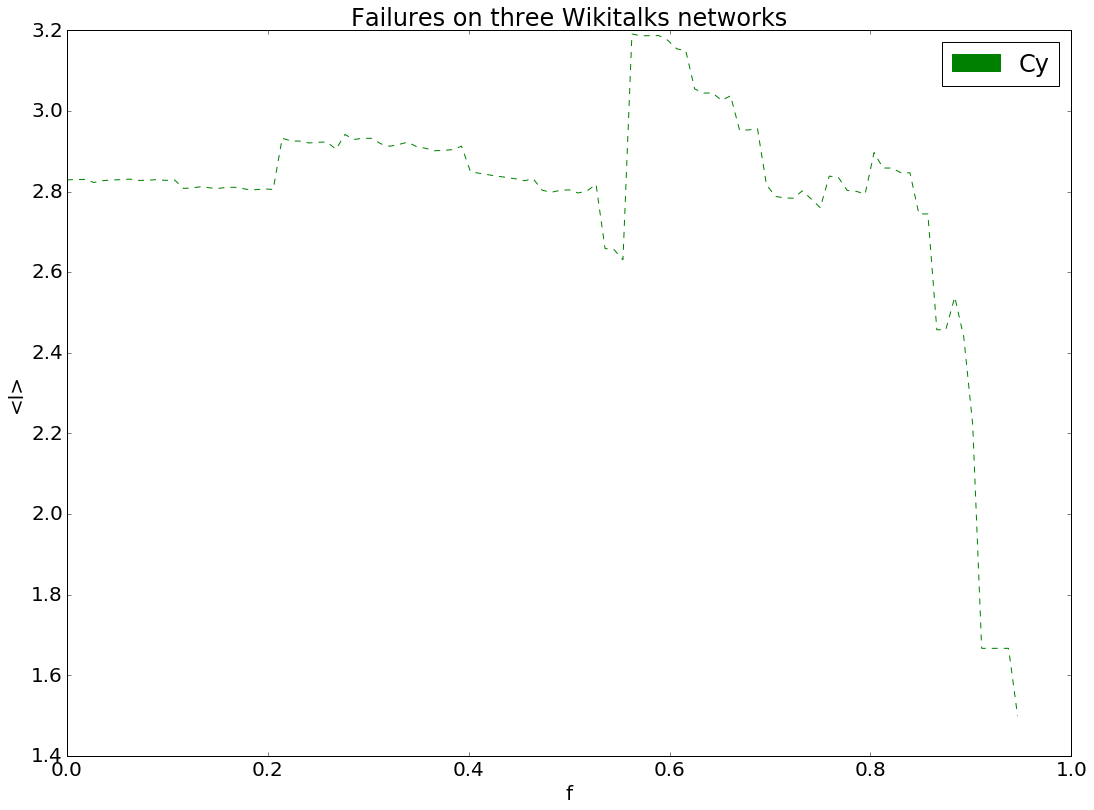

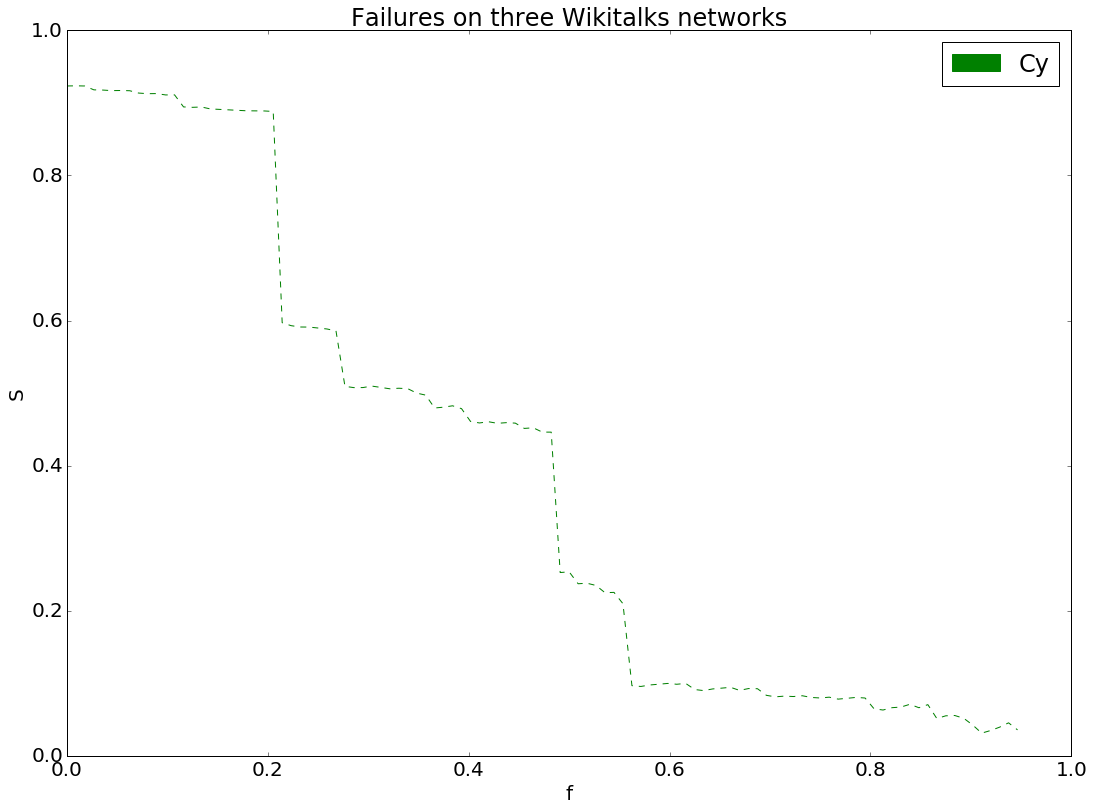

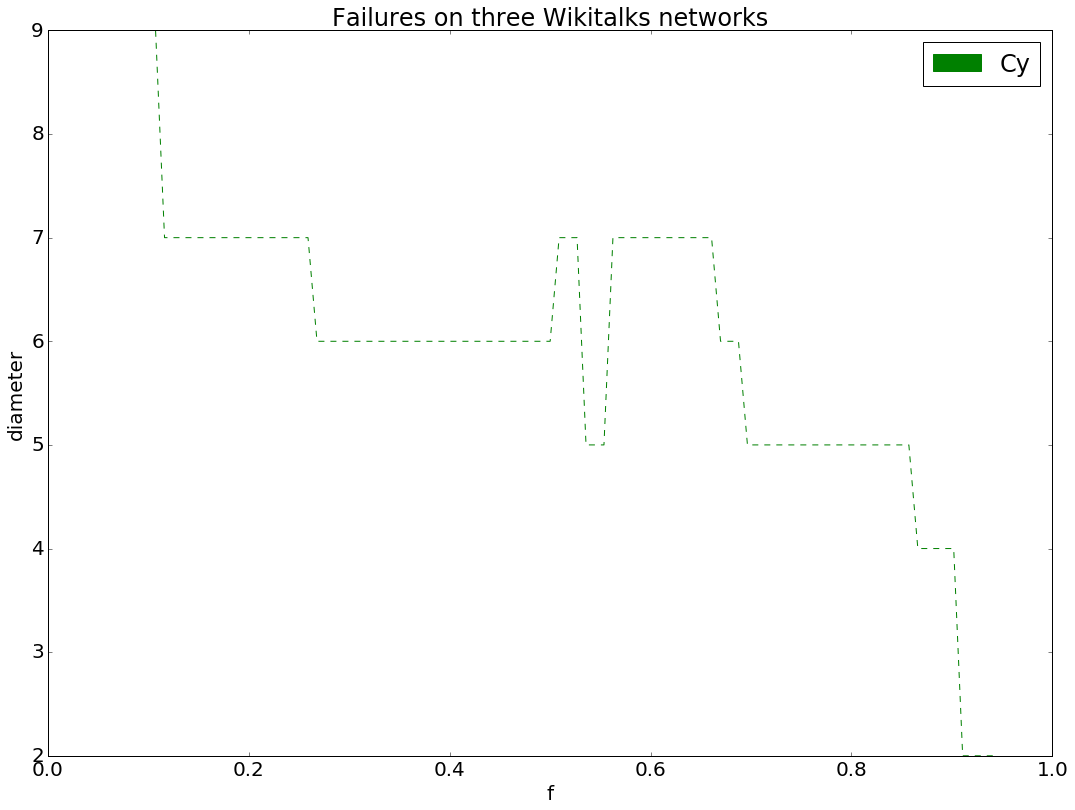

In [31]:
xvalues = [(float(x)/float(NetworkSize_cy))  for x in range(len(C_path_lengths
                                                                  ))]
fig_size = [18,13]
plt.rcParams.update({'font.size': 20, "figure.figsize": fig_size})

plt.plot(xvalues, C_path_lengths, '--g')
green_patch = mpatches.Patch(color='green', label='Cy')
plt.legend(handles=[green_patch])
plt.xlabel('f')
plt.ylabel('<l>')
plt.title('Failures on three Wikitalks networks')
plt.show()

plt.plot(xvalues, C_gcs, '--g')
green_patch = mpatches.Patch(color='green', label='Cy')
plt.legend(handles=[green_patch])
plt.xlabel('f')
plt.ylabel('S')
plt.title('Failures on three Wikitalks networks')
plt.show()

plt.plot(xvalues, C_diameters, '--g')
green_patch = mpatches.Patch(color='green', label='Cy')
plt.legend(handles=[green_patch])
plt.xlabel('f')
plt.ylabel('diameter')
plt.title('Failures on three Wikitalks networks')
plt.show()